In [29]:
import pygplates
import pandas as pd
import sys
sys.path.append('/Users/Simon/GIT/PlateTectonicTools/')
import ptt.subduction_convergence as sc
import matplotlib.pyplot as plt

%matplotlib inline

print pygplates.__version__

class ReconstructionModel(object):
    
    def __init__(self, name):
        self.name = name
        self.rotation_model = []    # creates a new empty list for each dog
        self.static_polygons = []
        self.dynamic_polygons = []

    def add_rotation_model(self, rotation_file):
        self.rotation_model.append(rotation_file)
        
    def add_static_polygons(self, static_polygons_file):
        self.static_polygons.append(static_polygons_file)
        
    def add_dynamic_polygons(self, dynamic_polygons_file):
        self.dynamic_polygons.append(dynamic_polygons_file)
        
    def plate_snapshot(self, reconstruction_time, anchor_plate_id=0):
        resolved_topologies = []
        resolved_topological_sections = []
        pygplates.resolve_topologies(self.dynamic_polygons, 
                                     self.rotation_model,
                                     resolved_topologies, 
                                     reconstruction_time,
                                     resolved_topological_sections,
                                     anchor_plate_id=anchor_plate_id)
        
        return PlateSnapshot(resolved_topologies,
                             resolved_topological_sections,
                             self.rotation_model,
                             reconstruction_time,
                             anchor_plate_id)
    
    def subduction_convergence(self, reconstruction_time, 
                              velocity_delta_time=1.,
                              threshold_sampling_distance_radians=2,
                              anchor_plate_id=0):

        result = sc.subduction_convergence(
            self.rotation_model,
            self.dynamic_polygons,
            threshold_sampling_distance_radians,
            reconstruction_time,
            velocity_delta_time,
            anchor_plate_id)
        
        # Make a flat list of subduction stats to input into the proximity test
        subduction_data = []
        for data in result:
            subduction_data.append(data+(reconstruction_time,))
    
        # Data frame template defining the column names
        DataFrameTemplate = ('lon','lat','conv_rate','conv_obliq','migr_rate',
                             'migr_obliq','arc_length','arc_azimuth',
                             'subducting_plate','overriding_plate','time')
        
        # convert list array to dataframe
        df = pd.DataFrame(subduction_data, columns = DataFrameTemplate)
        
        return SubductionConvergence(df)
        

class PlateSnapshot(object):
    def __init__(self, 
                 resolved_topologies,
                 resolved_topological_sections,
                 rotation_model,
                 reconstruction_time,
                 anchor_plate_id):
        
        self.reconstruction_time = reconstruction_time
        self.anchor_plate = anchor_plate_id
        self.rotation_model = rotation_model
        self.plate_count = len(resolved_topologies)
        self.plate_ids = [resolved_topology.get_resolved_feature().get_reconstruction_plate_id() \
                          for resolved_topology in resolved_topologies]
        self.plate_areas = [resolved_topology.get_resolved_geometry().get_area() * pygplates.Earth.mean_radius_in_kms\
                            for resolved_topology in resolved_topologies]
        self.plate_perimeters = [resolved_topology.get_resolved_geometry().get_arc_length() * pygplates.Earth.mean_radius_in_kms\
                            for resolved_topology in resolved_topologies] 
        self.plate_centroids = [resolved_topology.get_resolved_geometry().get_interior_centroid()\
                                for resolved_topology in resolved_topologies]


class SubductionConvergence(object):
    
    def __init__(self, df):
        self.df = df
    

    def plot(self):
        plt.figure()
        plt.scatter(self.df.lon, self.df.lat,c=self.df.conv_rate,edgecolors='')
        plt.show()


M2016 = ReconstructionModel('Matthews++2016')
M2016.add_rotation_model('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot')
M2016.add_static_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/StaticPolygons/Muller_etal_AREPS_2016_StaticPolygons.gpmlz')
M2016.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz')
M2016.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz')
M2016.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_TopologyBuildingBlocks.gpmlz')
#a.subduction_convergence(...).plot()
#print a.dynamic_polygons


2.0.0.12


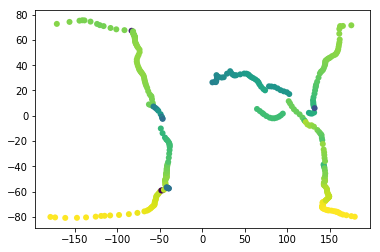

In [30]:
data = M2016.subduction_convergence(120.,threshold_sampling_distance_radians=5.)

data.plot()


[802, 983, 501, 715, 409, 714, 701, 201, 901, 926, 528, 801, 529, 307, 308, 806, 787, 301, 530, 304, 224, 985, 982, 101, 902, 908]
[4210.808503163929, 1494.3191424595286, 4748.969817659885, 2179.243968445578, 336.1779265624486, 2540.069968323993, 3993.1032336325447, 4898.813124174486, 10979.309863786782, 7613.223226422543, 295.6256879143814, 5781.983867713583, 729.885926738463, 153.62617098328832, 430.9013403381319, 117.12938319831497, 541.4899334289955, 9748.89091669542, 703.7970571895778, 292.5288210497033, 918.1365179891385, 999.9511280402442, 909.3335405114641, 6304.611008264638, 6345.128531265877, 2793.4016754665677]


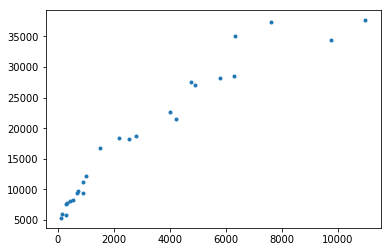

In [32]:
s = M2016.plate_snapshot(90.)

plt.plot(s.plate_areas,s.plate_perimeters,'.')


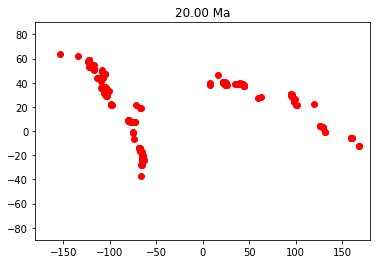

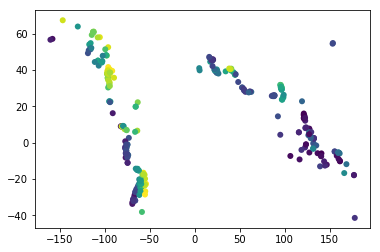

In [36]:
class age_coded_point_dataset(object):
  
    def __init__(self, df, longitude_field, latitude_field, age_field):
        self.df = df
        self.point_features = []
        for index,row in df.iterrows():
            point = pygplates.PointOnSphere(float(row[latitude_field]),float(row[longitude_field]))
            point_feature = pygplates.Feature()
            point_feature.set_geometry(point)
            point_feature.set_valid_time(row[age_field],-999.)
            self.point_features.append(point_feature)
        
            
    def assign_reconstruction_model(self,reconstruction_model):
        partitioned_point_features = pygplates.partition_into_plates(reconstruction_model.static_polygons,
                                                                     reconstruction_model.rotation_model,
                                                                     self.point_features)
        self.point_features = partitioned_point_features
        self.reconstruction_model = reconstruction_model
    
    
    def reconstruct(self,reconstruction_time,anchor_plate_id=0):
        reconstructed_features = []
        pygplates.reconstruct(self.point_features,
                              self.reconstuction_model.rotation_model,
                              reconstructed_features,
                              reconstruction_time,
                              anchor_plate_id=anchor_plate_id)
        
        return reconstructed_features
    
    
    def plot_reconstructed(self,reconstruction_time,anchor_plate_id=0):
        reconstructed_features = []
        pygplates.reconstruct(self.point_features,
                              self.reconstruction_model.rotation_model,
                              reconstructed_features,
                              reconstruction_time,
                              anchor_plate_id=anchor_plate_id)
        
        plt.figure()
        for reconstructed_feature in reconstructed_features:
            plt.plot(reconstructed_feature.get_reconstructed_geometry().to_lat_lon()[1],
                     reconstructed_feature.get_reconstructed_geometry().to_lat_lon()[0],'ro')
            plt.axis([-180,180,-90,90])
        plt.title('%0.2f Ma' % reconstruction_time)
        plt.show()
        
        
    def reconstruct_to_time_of_appearance(self,ReconstructTime='BirthTime',anchor_plate_id=0):
        
        rotation_model = pygplates.RotationModel(self.reconstruction_model.rotation_model)
        recon_points = []
        for point_feature in self.point_features:
            if ReconstructTime is 'MidTime':
                time = (point_feature.get_valid_time()[0]+point_feature.get_valid_time()[1])/2.
            else:
                time = point_feature.get_valid_time()[0]
            if point_feature.get_reconstruction_plate_id()!=0:
                point_rotation = rotation_model.get_rotation(time,
                                                             point_feature.get_reconstruction_plate_id(),
                                                             anchor_plate_id=anchor_plate_id)
                reconstructed_point = point_rotation * point_feature.get_geometry()
                recon_points.append([reconstructed_point.to_lat_lon()[1],
                                     reconstructed_point.to_lat_lon()[0],
                                     time])
            
        return recon_points
    

df = pd.read_csv('/Users/Simon/Data/TimeEncodedData/Yanites+Kesler/ngeo2429-s2.csv',index_col='Deposit number')


t = age_coded_point_dataset(df,'Long.','Lat.','Age (Ma)')

t.assign_reconstruction_model(M2016)

rt = t.plot_reconstructed(20.)


rbt = t.reconstruct_to_time_of_appearance()

plt.figure()
plt.scatter(zip(*rbt)[0],zip(*rbt)[1],c=zip(*rbt)[2],edgecolors='')



In [ ]:
import numpy as np
import healpy as hp


class point_distribution_on_sphere(object):

    def __init__(self, 'type'=random, N=10000):
        
        if 'type'=='healpix':               
            othetas,ophis = hp.pix2ang(N,np.arange(12*N**2))
            othetas = np.pi/2-othetas
            ophis[ophis>np.pi] -= np.pi*2

            # ophis -> longitude, othetas -> latitude
            return np.degrees(ophis), np.degrees(othetas)

        elif 'type'=='random'
            # function to call Marsaglia's method and return Long/
            # Lat arrays

            ## Marsaglia's method
            dim = 3
            norm = np.random.normal
            normal_deviates = norm(size=(dim, N))

            radius = np.sqrt((normal_deviates**2).sum(axis=0))
            points = normal_deviates/radius

            Long=[], Lat=[]
            for xyz in points.T:
                LL = pygplates.PointOnSphere((xyz))
                Lat.append(LL.to_lat_lon()[0])
                Long.append(LL.to_lat_lon()[1])

            return np.array(Long), np.array(Lat)

        

        